In [1]:
#!g1.1
import os
import pandas as pd
import numpy as np

import librosa
import wave

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as FA
import torchaudio
import torchaudio.transforms as TA
import torchlibrosa as TL
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning import LightningModule

import string
from pathlib import Path
from typing import Optional



from torchvision import models
from torchsummary import summary

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Audio

# 1. Анализ данных


## 1.1 Русский датасет


In [2]:
#!g1.1
rus_data = pd.read_csv ("data_with_melspecs.tsv", sep = '\t', index_col=0)
rus_data.head()

,name,text,speaker_id,record_id,mel_name
0,1d0ce85a331e2753c2b2a853f1a960e5.wav,выключи свет,3_2401,5caa53de-44e6-4a96-b803-d4d89542baa4,1d0ce85a331e2753c2b2a853f1a960e5.pt
1,bb3353e47b6813b94c982f30a9f88188.wav,окей,3_2445,db0a430e-0070-4358-a4e9-500ef4fb8b17,bb3353e47b6813b94c982f30a9f88188.pt
2,4de841b9fa74fa5517fc74546acc2143.wav,громкость три,3_2369,3e13ce56-bdb1-444e-b6af-a20d7f6252fb,4de841b9fa74fa5517fc74546acc2143.pt
3,bd67d83067d2d6bd53f66c5ae727b76f.wav,включи мультики,3_2455,64925ef8-bfce-4dd4-9043-ad051018a18c,bd67d83067d2d6bd53f66c5ae727b76f.pt
4,70fdd1e52713ba7523b9b0d1f8b4dc8e.wav,давай следующую,2_2219,2244d9f2-baa5-4a1c-87da-67ae024c111b,70fdd1e52713ba7523b9b0d1f8b4dc8e.pt


In [3]:
#!g1.1
rus_data.text.value_counts()

сделай тише        1747
выключи музыку     1739
пока               1713
играй              1697
хорошо             1692
                   ... 
настрой колонку     359
замолчи             358
песня               357
чего                349
номер два           336
Name: text, Length: 200, dtype: int64

In [4]:
#!g1.1
# 0th class is "UNK"
N_CLASSES = rus_data.text.nunique() + 1
UNK = "UNK"
UNK_CLASS = 0

print(f"N_CLASSES = {N_CLASSES}")
print(f"data size = {len(rus_data)}")

str_ids = sorted(rus_data.text.unique())

# 0 is for "UNK"
id2number = {str_id: number+1 for number, str_id in enumerate(str_ids)}
id2number[UNK] = UNK_CLASS
number2id = {number: str_id for str_id, number in id2number.items()}

N_CLASSES = 201
data size = 163872


In [5]:
#!g1.1
import pickle

In [6]:
#!g1.1
with open('dict/id2number.pkl', 'wb') as f:
    pickle.dump(id2number, f)
    
with open('dict/number2id.pkl', 'wb') as f:
    pickle.dump(number2id, f)

## 1.2 Английский датасет


In [7]:
#!g1.1
train_data = pd.read_csv ("train_with_melspecs.tsv", sep = '\t', index_col=0)
train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment,speaker_id,text,record_id,mel_name,name
0,425089f4d7e24cdf6861d0130323ec2e41bfc19e35bce5...,common_voice_en_20293205.mp3,He did not explain nor excuse himself.,2,0,NaN,NaN,NaN,en,NaN,425089f4d7e24cdf6861d0130323ec2e41bfc19e35bce5...,He did not explain nor excuse himself.,NaN,common_voice_en_20293205.pt,common_voice_en_20293205.mp3
1,428e4a7ea666e34f5fc14e974012d007c43fde67a77e21...,common_voice_en_20783579.mp3,Trivers' theory is very powerful.,2,1,NaN,NaN,NaN,en,NaN,428e4a7ea666e34f5fc14e974012d007c43fde67a77e21...,Trivers' theory is very powerful.,NaN,common_voice_en_20783579.pt,common_voice_en_20783579.mp3
2,429678b0833edff53f4e34e0f75c397a168b607a8bd116...,common_voice_en_23612304.mp3,Arsenal: contemporary art exhibitions.,2,0,twenties,male,NaN,en,NaN,429678b0833edff53f4e34e0f75c397a168b607a8bd116...,Arsenal: contemporary art exhibitions.,NaN,common_voice_en_23612304.pt,common_voice_en_23612304.mp3
3,42b4b33626b4173347210d0959772ef2ee1a58b27a6b0a...,common_voice_en_27703528.mp3,The More Things Change...,2,0,fourties,male,NaN,en,NaN,42b4b33626b4173347210d0959772ef2ee1a58b27a6b0a...,The More Things Change...,NaN,common_voice_en_27703528.pt,common_voice_en_27703528.mp3
4,42ea9e2ee0ae9ee3782def9c4ceba6e6415f3960e8485e...,common_voice_en_19656330.mp3,“What do you mean to do?” cried Maja.,2,0,NaN,NaN,NaN,en,NaN,42ea9e2ee0ae9ee3782def9c4ceba6e6415f3960e8485e...,“What do you mean to do?” cried Maja.,NaN,common_voice_en_19656330.pt,common_voice_en_19656330.mp3


In [8]:
#!g1.1
len(train_data)

114364

In [9]:
#!g1.1
data = pd.concat([rus_data, train_data[rus_data.columns]]).reset_index(drop=True)
data

,name,text,speaker_id,record_id,mel_name
0,1d0ce85a331e2753c2b2a853f1a960e5.wav,выключи свет,3_2401,5caa53de-44e6-4a96-b803-d4d89542baa4,1d0ce85a331e2753c2b2a853f1a960e5.pt
1,bb3353e47b6813b94c982f30a9f88188.wav,окей,3_2445,db0a430e-0070-4358-a4e9-500ef4fb8b17,bb3353e47b6813b94c982f30a9f88188.pt
2,4de841b9fa74fa5517fc74546acc2143.wav,громкость три,3_2369,3e13ce56-bdb1-444e-b6af-a20d7f6252fb,4de841b9fa74fa5517fc74546acc2143.pt
3,bd67d83067d2d6bd53f66c5ae727b76f.wav,включи мультики,3_2455,64925ef8-bfce-4dd4-9043-ad051018a18c,bd67d83067d2d6bd53f66c5ae727b76f.pt
4,70fdd1e52713ba7523b9b0d1f8b4dc8e.wav,давай следующую,2_2219,2244d9f2-baa5-4a1c-87da-67ae024c111b,70fdd1e52713ba7523b9b0d1f8b4dc8e.pt
...,...,...,...,...,...
278231,common_voice_en_28823379.mp3,This is called the Oberth effect.,372293e65cdab88771e028a4351651ab2eff64438ddafc...,NaN,common_voice_en_28823379.pt
278232,common_voice_en_28823419.mp3,Figgins was not signed by another team.,372293e65cdab88771e028a4351651ab2eff64438ddafc...,NaN,common_voice_en_28823419.pt
278233,common_voice_en_28823440.mp3,All these washi are still made today.,372293e65cdab88771e028a4351651ab2eff64438ddafc...,NaN,common_voice_en_28823440.pt
278234,common_voice_en_28823450.mp3,"They play at Farum Park, in Farum West.",372293e65cdab88771e028a4351651ab2eff64438ddafc...,NaN,common_voice_en_28823450.pt


In [10]:
#!g1.1
len(data)

278236

In [11]:
#!g1.1
data.to_csv('mixed_data_with_melspecs.tsv', sep='\t')

In [12]:
#!g1.1
data.text

0                                    выключи свет
1                                            окей
2                                   громкость три
3                                 включи мультики
4                                 давай следующую
                           ...                   
278231          This is called the Oberth effect.
278232    Figgins was not signed by another team.
278233      All these washi are still made today.
278234    They play at Farum Park, in Farum West.
278235             McCrossan was born in Toronto.
Name: text, Length: 278236, dtype: object

# 2 Датасет


In [13]:
#!g1.1
class SDAProjectDataset(Dataset):
    def __init__(self, data_dir: str):
        data_path = Path(data_dir)
        tsv_path = data_path / 'mixed_data_with_melspecs.tsv'
        info = pd.read_csv(tsv_path, sep='\t', low_memory=False)
        self.paths = \
            list(map(lambda x: data_path / 'melspecs' / x, info['mel_name']))
        texts = list(info['text'])
        self.labels = self._get_labels(texts)
        
    def _get_labels(self, texts):
        labels = list(0 for _ in range(len(texts)))

        for i, text in enumerate(texts):
            labels[i] = id2number.get(text, 0)
            
        return labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        melspec = torch.load(path)

        return melspec, label


class Collator:
    def __call__(self, batch):
        melspecs, labels = zip(*batch)

        lengths = list()
        for melspec in melspecs:
            lengths.append(melspec.size(-1))

        # -11.52 is torch.log(1e-5) - padding for zero noise
        batch_melspecs = -11.52 * torch.ones(
            len(batch),
            melspecs[0].shape[1],
            max(lengths),
        )
        for i, (melspec, length) in enumerate(zip(melspecs, lengths)):
            batch_melspecs[i, :, :length] = melspec.squeeze()

        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()

        return {
            'melspecs': batch_melspecs,
            'labels': labels,
            'lengths': lengths,
        }


class SDAProjectDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        batch_size: int = 8,
        num_workers: int = 1,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: Optional[str] = None, ratios=(0.8, 0.1, 0.1)):
        full_dataset = SDAProjectDataset(self.data_dir)
        test_dataset_length = int(ratios[2] * len(full_dataset))
        val_dataset_length = int(ratios[1] * len(full_dataset))
        train_dataset_length = \
            len(full_dataset) - test_dataset_length - val_dataset_length
        trainval_dataset, self.test_dataset = random_split(
            dataset=full_dataset,
            lengths=(
                train_dataset_length + val_dataset_length,
                test_dataset_length,
            )
        )
        self.train_dataset, self.val_dataset = random_split(
            dataset=trainval_dataset,
            lengths=(train_dataset_length, val_dataset_length),
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            collate_fn=Collator(),
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            collate_fn=Collator(),
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            collate_fn=Collator(),
            num_workers=self.num_workers,
        )


# 3  Модель (MatchBox)


Архитектура из https://arxiv.org/pdf/2004.08531.pdf


In [14]:
#!g1.1
class ConvSubBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=11, stride=1, dilation=1, p=0.0):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            # 1D Depth-wise
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=k,
                stride=stride,
                dilation=dilation,
                padding=dilation * (k - 1) // 2,
                bias=False
            ),
            # Pointwise (Time-wise)
            nn.Conv1d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                padding="same"
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p)
        )
        

    def forward(self, x):
        return self.conv_block(x)

In [15]:
#!g1.1
class MatchBoxBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=13, p=0.0):
        super().__init__()
        
        self.conv_block = ConvSubBlock(
            in_channels=in_channels, out_channels=out_channels, 
            k=k, p=p)     

    def forward(self, x):
        return self.conv_block(x)

In [16]:
#!g1.1
from IPython.core.display import clear_output

def smooth(array, window_size):
    return [np.mean(array[max(0, i - window_size): i + 1]) for i in range(len(array))]

In [17]:
#!g1.1
class MatchBox(LightningModule):
    def __init__(self, n_classes: int = 200):
        super().__init__()
        
        self.conv1 = ConvSubBlock(in_channels=128, out_channels=128, stride=2, k=11)
        
        self.box1 = MatchBoxBlock(in_channels=128, out_channels=64, k=13)
        self.box2 = MatchBoxBlock(in_channels=64, out_channels=64, k=15)
        self.box3 = MatchBoxBlock(in_channels=64, out_channels=64, k=17)
        
        self.conv2 = ConvSubBlock(in_channels=64, out_channels=128, dilation=2, k=29)
        self.conv3 = ConvSubBlock(in_channels=128, out_channels=128, k=1)
        
        self.end = nn.Sequential(
            nn.Conv1d(
                in_channels=128,
                out_channels=n_classes,
                kernel_size=1,
            ),
            nn.AdaptiveMaxPool1d(output_size=1),
        )
        self.criterion = nn.CrossEntropyLoss()
        
        # History
        self.train_loss_history = []
        self.val_loss_history = []
        
        self.train_acc_history = []
        self.train_fnr_history = []
        self.train_fpr_history = []
        self.val_acc_history = []
        self.val_fnr_history = []
        self.val_fpr_history = []
        
        self.last_train_outputs = None
        self.window_size = 5

        

    def forward(self, x) -> torch.Tensor:
        probs = self.end(self.conv3(self.conv2(
            self.box3(self.box2(self.box1(self.conv1(x))))
        )))
        probs = probs.squeeze(2)
        return probs

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        melspecs = batch['melspecs']
        labels = batch['labels']
        outputs = self.forward(melspecs)
        loss = self.criterion(outputs, labels)  
        
        pred_cl = outputs.argmax(dim=1)
        correct = torch.sum((pred_cl==labels))
        total = len(labels)
        
        fp = torch.sum((pred_cl!=labels)&(labels==0))
        neg = torch.sum(labels==0)
        fn = torch.sum((pred_cl!=labels)&(labels!=0))
        pos = torch.sum(labels!=0)
        
        self.log(f"train_loss", loss)
        return {"loss": loss, "correct": correct, "total": total,
               "fp": fp, "unknown": neg,
               "fn": fn, "phrases": pos}
    
    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        melspecs = batch['melspecs']
        labels = batch['labels']
        outputs = self.forward(melspecs)
        loss = self.criterion(outputs, labels)
        
        pred_cl = outputs.argmax(dim=1)
        correct = torch.sum((pred_cl==labels))
        total = len(labels)
        
        fp = torch.sum((pred_cl!=labels)&(labels==0))
        neg = torch.sum(labels==0)
        fn = torch.sum((pred_cl!=labels)&(labels!=0))
        pos = torch.sum(labels!=0)
        
        self.log(f"val_loss", loss)
        return {"loss": loss, "correct": correct, "total": total,
               "fp": fp, "unknown": neg,
               "fn": fn, "phrases": pos}
    
    
    def training_epoch_end(self, outputs):
        loss_values = [float(output['loss']) for output in outputs]
        avg_loss = np.mean(loss_values)
        
        total =  np.sum([output['total'] for output in outputs])
        acc = np.sum([output['correct'] for output in outputs]) / total       
                                   
        neg = np.sum([output['unknown'] for output in outputs])
        fpr = np.sum([output['fp'] for output in outputs]) / neg
            
        pos = np.sum([output['phrases'] for output in outputs])
        fnr = np.sum([output['fn'] for output in outputs]) / neg
        
        self.train_loss_history.append(avg_loss) 
        self.train_acc_history.append(acc)
        self.train_fnr_history.append(fnr)
        self.train_fpr_history.append(fpr)
          
        self.last_train_outputs = outputs
   
     
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean([float(output['loss']) for output in outputs])
        self.val_loss_history.append(avg_loss)

        # train logs
        if self.last_train_outputs:
            clear_output()
            fig, axs = plt.subplots(1, 4, figsize=(18, 4))

            axs[0].plot(range(len(self.train_loss_history)), self.train_loss_history, label="loss")
            axs[0].plot(
                range(len(self.train_loss_history)),
                smooth(self.train_loss_history, window_size=self.window_size),
                label=f"{self.window_size}-smooth loss",
                c="aqua"
            )
            axs[0].set_xlabel("epoch")
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(range(len(self.train_acc_history)), self.train_acc_history, label="accuracy")
            axs[1].set_xlabel("epoch")
            axs[1].set_ylim([0.0, 1.0])
            axs[1].legend()
            axs[1].grid(True)
        
            axs[2].plot(range(len(self.train_fpr_history)), self.train_fpr_history, label="fpr")
            axs[2].set_xlabel("epoch")
            axs[2].set_ylim([0.0, 1.0])
            axs[2].legend()
            axs[2].grid(True)
        
            axs[3].plot(range(len(self.train_fnr_history)), self.train_fnr_history, label="fnr")
            axs[3].set_xlabel("epoch")
            axs[3].set_ylim([0.0, 1.0])
            axs[3].legend()
            axs[3].grid(True)
            
            plt.show()

            
            total =  np.sum([output['total'] for output in self.last_train_outputs])
            acc = np.sum([output['correct'] for output in self.last_train_outputs]) / total
                                   
            neg = np.sum([output['unknown'] for output in self.last_train_outputs])
            fpr = np.sum([output['fp'] for output in self.last_train_outputs]) / neg
            
            pos = np.sum([output['phrases'] for output in self.last_train_outputs])
            fnr = np.sum([output['fn'] for output in self.last_train_outputs]) / pos
                               
            print(f"Train loss: {self.train_loss_history[-1]:.3f}\t" \
                  f"Accuracy: {acc}\t", f"Total: {total}\t")
            print(f"FPR: {fpr}\t", f"Total Unknown: {neg}\t")
            print(f"FNR: {fnr}\t", f"Total Act-Phrases: {pos}\t")

            
        # val metrics    
        total_v =  np.sum([output['total'] for output in outputs])
        acc = np.sum([output['correct'] for output in outputs]) / total_v       
                                   
        neg = np.sum([output['unknown'] for output in outputs])
        fpr = np.sum([output['fp'] for output in outputs]) / neg
            
        pos = np.sum([output['phrases'] for output in outputs])
        fnr = np.sum([output['fn'] for output in outputs]) / pos
        
        self.val_acc_history.append(acc)
        self.val_fnr_history.append(fnr)
        self.val_fpr_history.append(fpr)
            
        # val logs
        fig, axs = plt.subplots(1, 4, figsize=(18, 4))

        axs[0].plot(range(len(self.val_loss_history)), self.val_loss_history, label="loss")
        axs[0].plot(
            range(len(self.val_loss_history)),
            smooth(self.val_loss_history, window_size=self.window_size),
            label=f"{self.window_size}-smooth loss",
            c="aqua"
        )
        axs[0].set_xlabel("epoch")
        axs[0].legend()
        axs[0].grid(True)
        
        axs[1].plot(range(len(self.val_acc_history)), self.val_acc_history, label="accuracy")
        axs[1].set_xlabel("epoch")
        axs[1].set_ylim([0.0, 1.0])
        axs[1].legend()
        axs[1].grid(True)
        
        axs[2].plot(range(len(self.val_fpr_history)), self.val_fpr_history, label="fpr")
        axs[2].set_xlabel("epoch")
        axs[2].set_ylim([0.0, 1.0])
        axs[2].legend()
        axs[2].grid(True)
        
        axs[3].plot(range(len(self.val_fnr_history)), self.val_fnr_history, label="fnr")
        axs[3].set_xlabel("epoch")
        axs[3].set_ylim([0.0, 1.0])
        axs[3].legend()
        axs[3].grid(True)
        
        plt.show()
        
        print(f"Val loss: {self.val_loss_history[-1]:.3f}\t" \
              f"Accuracy: {acc}\t", f"Total: {total_v}\t")
        print(f"FPR: {fpr}\t", f"Total Unknown: {neg}\t")
        print(f"FNR: {fnr}\t", f"Total Act-Phrases: {pos}\t")


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer 

In [18]:
#!g1.1
tmp_model = MatchBox(n_classes = N_CLASSES)
tmp_model = tmp_model.cuda()
size = (128, 377)
summary(tmp_model, size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 189]         180,224
            Conv1d-2             [-1, 128, 189]          16,512
       BatchNorm1d-3             [-1, 128, 189]             256
              ReLU-4             [-1, 128, 189]               0
           Dropout-5             [-1, 128, 189]               0
      ConvSubBlock-6             [-1, 128, 189]               0
            Conv1d-7              [-1, 64, 189]         106,496
            Conv1d-8              [-1, 64, 189]           4,160
       BatchNorm1d-9              [-1, 64, 189]             128
             ReLU-10              [-1, 64, 189]               0
          Dropout-11              [-1, 64, 189]               0
     ConvSubBlock-12              [-1, 64, 189]               0
    MatchBoxBlock-13              [-1, 64, 189]               0
           Conv1d-14              [-1, 

# 4 Обучение модели


In [19]:
#!g1.1
data_dir = '.'
datamodule = SDAProjectDataModule(data_dir=data_dir, num_workers = 8)
logger = None
model = MatchBox(n_classes=N_CLASSES)

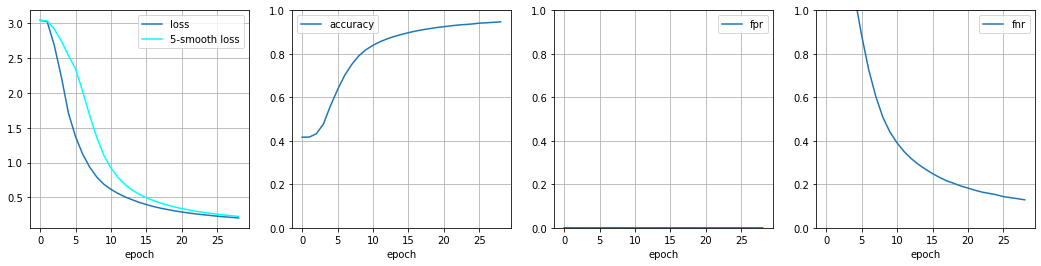

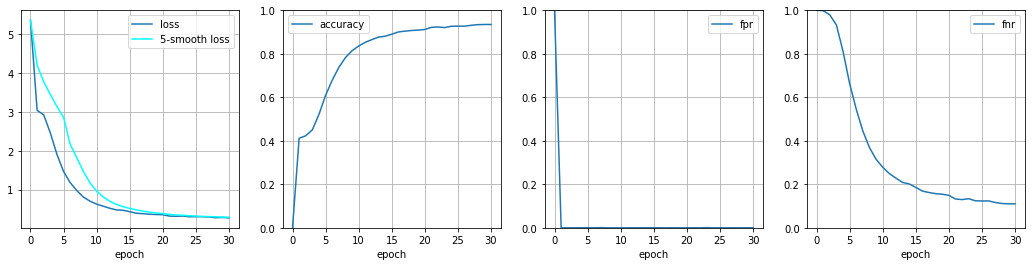

Train loss: 0.207	Accuracy: 0.9470505714416504	 Total: 222590	
FPR: 9.831660281633958e-05	 Total Unknown: 91541	
FNR: 0.08986715227365494	 Total Act-Phrases: 131049	
Val loss: 0.274	Accuracy: 0.9350178241729736	 Total: 27823	
FPR: 0.00017484046111349016	 Total Unknown: 11439	
FNR: 0.1102294921875	 Total Act-Phrases: 16384	



In [21]:
#!g1.1
trainer = pl.Trainer(max_epochs=30, gpus=int(torch.cuda.is_available()), log_every_n_steps=1, logger=logger)
trainer.fit(model, datamodule=datamodule)

In [22]:
#!g1.1
model_name = "MatchBox_3_1_64_V2"
torch.save(model.state_dict(), f'model_weights/{model_name}.pth')

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: datamodule, model, trainer
  warnings.warn(message)


In [ ]:
#!g1.1
